# Introduction

This project is implementing machine learning solutions to the Covid-19 ventilator control problem. 

Dataset used: https://www.kaggle.com/competitions/ventilator-pressure-prediction/overview


# Machine Learning Formulation
**Type of Machine Learning Problem**  
Time series regression problem

**Task, T**  
Predict the airway pressure in the respiratory circuit during the breath

**Performance, P**  
Mean squared error (MSE) and Mean absolute error (MAE) between predicted pressure and actual pressure during the inspiratory phase of each breath

**Experience, E**  
Lungs related information (percentage of opening of the inspiratory solenoid valve, state of exploratory valve) from each patient of a particular timestep 


# Loading all pre-requisite libraries

In [53]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from time import time

---
# Data Preprocessing

## 1. Loading data and understanding the dataset

| Features | Description |
| :---------: | :---------- |
| id | Globally-unique time step identifier across an entire file |
| breath_id | Globally-unique time step for breaths |
| R | Lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow. |
| C | Lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow. |
| time_step | The actual time stamp. |
| u_in | The control input for the inspiratory solenoid valve. Ranges from 0 to 100. |
| u_out | The control input for the exploratory solenoid valve. Either 0 or 1. |
| pressure | The airway pressure measured in the respiratory circuit, measured in cmH2O. |

In [54]:
# The data sets (train, test) is loaded
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [55]:
# Display the first 82 rows of the train dataset
train.head(82)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
77,78,1,20,50,2.621773,4.981847,1,6.329607
78,79,1,20,50,2.655746,4.984683,1,6.540513
79,80,1,20,50,2.689766,4.987079,1,6.470211
80,81,2,20,20,0.000000,12.184338,0,6.048398


After observing the train dataset, we discover that the **breath_id** changes for every 80 rows of instances. 

Therefore, we concluded that every 80 rows of data represents the lungs information of one patient.

In [56]:
# Display the first 5 rows of the test dataset
test.head()

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


In [57]:
# Checking the quantities rows of dataset with its variable
print("Train Data Shape: " , train.shape)
print("Test Data Shape: ", test.shape)

Train Data Shape:  (6036000, 8)
Test Data Shape:  (4024000, 7)


## 2. Checking the completeness of the dataset
To ensure that all required data is known.

In [58]:
# Checking if there are any missing values in the dataset (Returns True if it detects one)

print('Train Dataset')
print(train.isnull().sum())
print('\nTest Dataset')
print(test.isnull().sum())

Train Dataset
id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

Test Dataset
id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
dtype: int64


## 3. Checking the uniqueness of the dataset
To ensure that there are no duplicate datas which may cause overfitting.

In [59]:
# Checking if there are any duplicated values in the dataset (Returns True if it detects one)

print("The number of duplicated datas in the training dataset is: ", train.duplicated().sum())
print("The number of duplicated datas in the testing dataset is: ", test.duplicated().sum())

The number of duplicated datas in the training dataset is:  0
The number of duplicated datas in the testing dataset is:  0


## 4. Visualizing correlation of variables using heatmap

<AxesSubplot:>

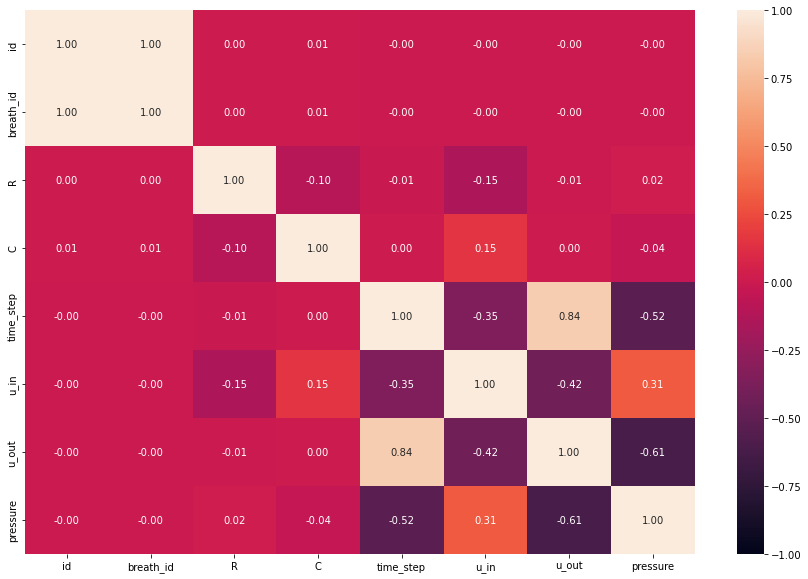

In [60]:
plt.figure(figsize = (15, 10))
sb.heatmap(train.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

From the heatmap above, it can be seen that the variables: **time_step, u_in, u_out**  and **pressure** are more correlated. 

Therefore, we decided to remove **id, breath_id, R** and **C** from the dataset before fitting it into our machine learning model.

In [61]:
train_drop = train.drop(['id', 'breath_id','R','C'], axis=1)
train_drop.head()

,time_step,u_in,u_out,pressure
0,0.000000,0.083334,0,5.837492
1,0.033652,18.383041,0,5.907794
2,0.067514,22.509278,0,7.876254
3,0.101542,22.808822,0,11.742872
4,0.135756,25.355850,0,12.234987


## 5. Visualizing distribution of data using boxplot

<AxesSubplot:>

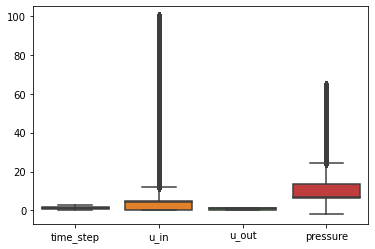

In [62]:
sb.boxplot(data = train_drop)

From the botplot above, we can observed many outliers present in our dataset from **u_in** and **pressure**.

Hence, we are not scaling our dataset because an outlier may have very big effect towards the scaled mean and scaled standard deviation.

## 6. Deciding a machine learning model and processing the data

As the dataset provided is arranged in a time-series manner, the first obvious choice in selecting an algorithm to build the model would be the **Recurrent Neural Network**.

After selecting the model, we must process the dataset into an appropriate form so it can be fit into the model without any problem.

In [63]:
training = np.array(train_drop[['time_step','u_in', 'u_out']], dtype='float32')
target = np.array(train_drop['pressure'], dtype='float32')

In [64]:
index = len(np.unique(train.breath_id))
data_per_batch = len(train[train.breath_id==1])
attribute = len(training[0])

print("Number of batches in the training set:" , index)
print("Number of data per batch:" , data_per_batch)
print("Number of attribute used:" , attribute)

Number of batches in the training set: 75450
Number of data per batch: 80
Number of attribute used: 3


In [65]:
training = np.reshape(training, (index, data_per_batch, attribute))
target = np.reshape(target, (index, data_per_batch, 1))

print('Training Data Shape: ', training.shape)
print('Target Data Shape: ', target.shape)

Training Data Shape:  (75450, 80, 3)
Target Data Shape:  (75450, 80, 1)


In [66]:
train_x, test_x, train_y, test_y = train_test_split(training, target, test_size = 0.2, random_state=159)
test_y = np.reshape(test_y, (test_y.shape[0], test_y.shape[1]))

---
# Building and training model

Each and every model will be evaluated by the MSE value, (mean squared error) and MAE (mean absolute error) between the actual target values and the predicted values.

Lower MSE and MAE value indicates better performance regarding to the dataset. The MSE and MAE value of each algorithm will be compared.

## Recurrent Neural Network (RNN)

A recurrent neural network (RNN) is a class of artificial neural networks where connections between nodes form a directed or undirected graph along a temporal sequence. This allows it to exhibit temporal dynamic behavior.

A RNN consists of three layers, input layer, hidden layer/recurrent layer and output layer
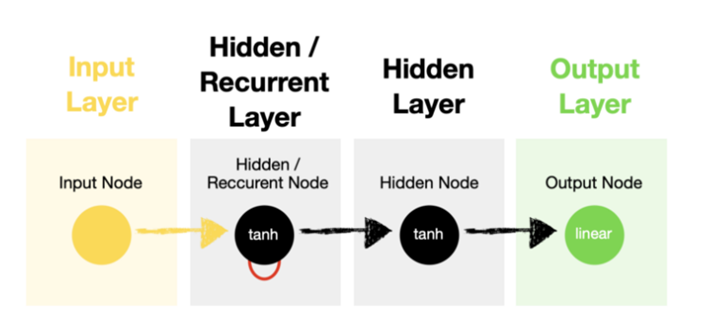

We use a variant of RNN which is Long-Short Term Memory Network that is effective in predicting data over a period of time,
which is suitable for this instance which includes time_step.

The activation function for the model will be Rectifier Linear Unit (RELU).
The function returns 0 if it receives any negative input, but for any positive value x it returns that value back

In [15]:
RNN_model = keras.Sequential()
RNN_model.add(layers.LSTM(128, input_shape=(data_per_batch, attribute), return_sequences=True))
RNN_model.add(layers.LSTM(64, return_sequences=True))
RNN_model.add(layers.Dense(1, activation='relu'))

# Callback stop training when no improvement in loss for 3 consecutive epoch
callback = keras.callbacks.EarlyStopping(monitor = "loss", mode = "min", patience = 3)

RNN_model.compile(loss="mae",
             optimizer="adam",
              metrics=['mse'])

RNN_model.summary()
RNN_model.fit(train_x, train_y, epochs=50, callbacks=[callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80, 128)           67584     
                                                                 
 lstm_1 (LSTM)               (None, 80, 64)            49408     
                                                                 
 dense (Dense)               (None, 80, 1)             65        
                                                                 
Total params: 117,057
Trainable params: 117,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1887/1887 [==============================] - 115s 60ms/step - loss: 2.0931 - mse: 16.9245
Epoch 2/50
1887/1887 [==============================] - 114s 61ms/step - loss: 1.4750 - mse: 8.6789
Epoch 3/50
1887/1887 [==============================] - 115s 61ms/step - loss: 1.3171 - mse: 7.3496
Epoch 4/50
18

In [16]:
RNN_prediction = RNN_model.predict(test_x)
RNN_prediction = np.reshape(RNN_prediction, (RNN_prediction.shape[0], RNN_prediction.shape[1]))

472/472 [==============================] - 11s 23ms/step


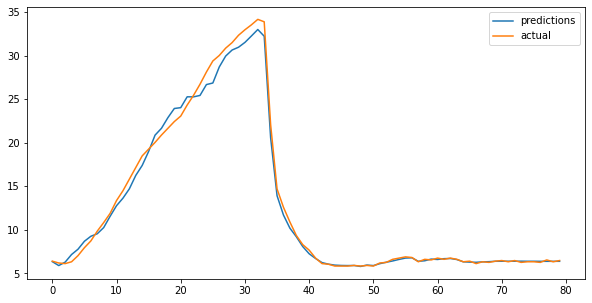

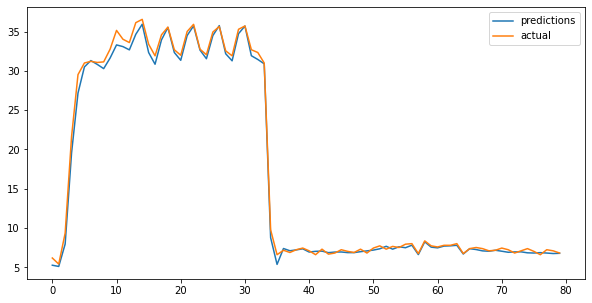

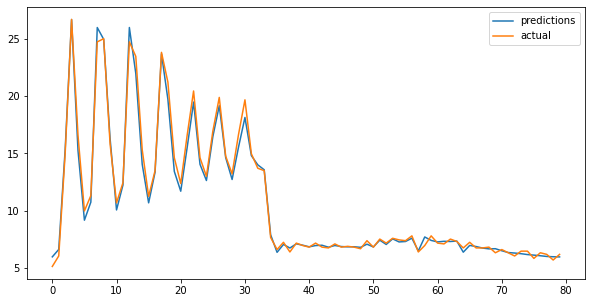

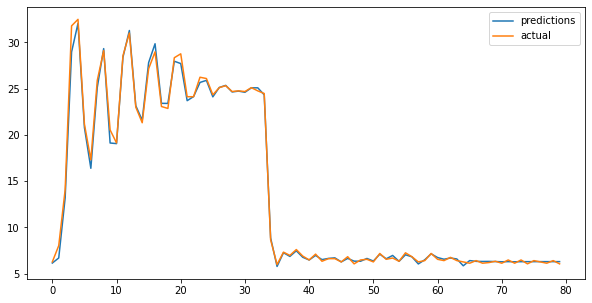

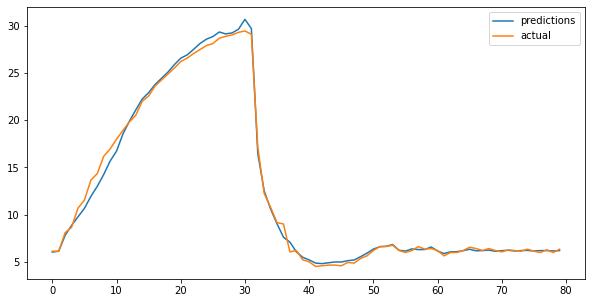

In [26]:
# Display five graphs displaying the predicted and actual results
for pred in range(5):
    plt.figure(figsize = (10,5))
    plt.plot(RNN_prediction[pred, :], label="predictions")
    plt.plot(test_y[pred, :], label="actual")
    leg = plt.legend(loc='upper right')    
    plt.show()

In [18]:
#print the MSE and MAE value of RNN using test_y 
print("MSE of RNN:",metrics.mean_squared_error(test_y, RNN_prediction))
print("MAE of RNN:",metrics.mean_absolute_error(test_y, RNN_prediction))

MSE of RNN: 2.613951
MAE of RNN: 0.6643523


---
# Experimentation: Can Classical Machine Learning Algorithm Outperform RNN?

Nowadays, people often choose to build neural network to solve machine learning problem due to its rising popularity. However, does it always give the best result when compared to classical machine learning algorithm? 

In the next part of this project, we will build and train classical machine learning algorithm such as **Linear Regression, K-Nearest Neighbour** and **Decision Tree** to find out can these algorithms outperform **Recurrent Neural Network** by having a lower MSE and MAE between the predicted pressure and actual pressure.

# Reformating the data with original information

This section serves to reformat the data for the usage of classical machine learning algorithms which does not take in data in 3-dimensional. Since the data is in a time-series manner, we would need to rearranged this in a way where each variable does not lose its meaning.
- Variable: time_step, u_in, u_out

Since each 80 data value represent a time series for a patient, we can flatten the 3 variables each with 80 data value into a single row vector and interpret the 3 variables as a single whole variable time step.

| time_step | u_in | u_out |
| :-: | :-: | :-: |
| 0.101 | 18.38 | 0 |
| 0.135 | 24.54 | 0 |
| $\vdots$ |$\vdots$|$\vdots$|
| 2.689 | 12.86 | 1 |

<center>$\downarrow$</center>

| time_step_1 | u_in_1 | u_out_1 | time_step_2 | u_in_2 | u_out_2 | $\ldots$ | time_step_80 | u_in_80 | u_out_80 |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| 0.101 | 18.38 | 0 | 0.135 | 24.54 | 0 | $\ldots$ | 2.689 | 12.86 | 1 |

In [67]:
ori_size = train_x.shape[1]*train_x.shape[2]

ori_dataset = np.empty((0, ori_size))
for i in range(train_x.shape[0]):
    add = np.reshape(train_x[i], (1, ori_size))
    ori_dataset = np.append(ori_dataset, add, axis=0) 

In [68]:
ori_testset = np.empty((0, ori_size))
for j in range(test_x.shape[0]):
    add1 = np.reshape(test_x[j], (1, ori_size))
    ori_testset = np.append(ori_testset, add1, axis=0)

In [69]:
train_y = np.reshape(train_y, (train_y.shape[0], train_y.shape[1]))
test_y = np.reshape(test_y, (test_y.shape[0], test_y.shape[1]))

# Reformating the data with prior information
Since the data is in a time-series manner, the target variable: pressure might be affected by data over a period of time instead of only from a particular time step. Therefore, we also tried to add in data from the prior time steps to train our model. 

- Variable: time_step, t1_u_in, u_in, diff_u_in, t1_u_out, u_out
    - t1_u_in: u_in from 1 time step prior
    - diff_u_in: difference of u_in and t1_u_in
    - t1_u_out: u_out from 1 time step prior

Since each 80 data value represent a time series for a person, we can flatten the 6 variables each with 80 data value into a single row vector and interpret the 6 variables as a single whole variable time step.

| time_step | t1_u_in | u_in | diff_u_in | t1_u_out | u_out |
| :-: | :-: | :-: | :-: | :-: | :-: |
| 0.0000 | 0.0000 | 0.0833 | 0.0833 | 0 | 0 |
| 0.0336 | 0.0833 | 18.3830 | 18.2997 | 0 | 0 |
| 0.0675 | 18.3830| 22.5092 | 4.1262 | 0 | 0 |
|$\vdots$|$\vdots$| $\vdots$ |$\vdots$|$\vdots$|$\vdots$|


<center>$\downarrow$</center>

| 1_time_step| 1_t1_u_in | 1_u_in | 1_diff_u_in | 1_t1_u_out | 1_u_out | 2_time_step | 2_t1_u_in | 2_u_in | 2_diff_u_in | $\ldots$ | 80_diff_u_in | 80_t1_u_out | 80_u_out |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|  0.0000 | 0.0000 | 0.0833 | 0.0833 | 0 | 0 | 0.0336 | 0.0833 | 18.3830 | 18.2997 | $\ldots$ | 0.2101 | 1 | 1 |

In [70]:
# Consider 1 time step prior for u_in and u_out

t1_u_in = train_drop['u_in'].shift()
t1_u_out = train_drop['u_out'].shift()

train_drop.insert(1, "t1_u_in", t1_u_in, allow_duplicates=True)
train_drop.insert(3, "t1_u_out", t1_u_out, allow_duplicates=True)

# for missing values(NaN) in the data, fill them with 0
train_drop.fillna(0, inplace=True)

diff_u_in = train_drop['u_in'] - train_drop['t1_u_in']
train_drop.insert(3, "diff_u_in", diff_u_in, allow_duplicates=True)

X = train_drop.drop(['pressure'], axis=1)
X

,time_step,t1_u_in,u_in,diff_u_in,t1_u_out,u_out
0,0.000000,0.000000,0.083334,0.083334,0.0,0
1,0.033652,0.083334,18.383041,18.299707,0.0,0
2,0.067514,18.383041,22.509278,4.126236,0.0,0
3,0.101542,22.509278,22.808822,0.299544,0.0,0
4,0.135756,22.808822,25.355850,2.547028,0.0,0
...,...,...,...,...,...,...
6035995,2.504603,1.420711,1.489714,0.069002,1.0,1
6035996,2.537961,1.489714,1.488497,-0.001217,1.0,1
6035997,2.571408,1.488497,1.558978,0.070481,1.0,1
6035998,2.604744,1.558978,1.272663,-0.286315,1.0,1


In [71]:
attribute_prior = X.shape[1]

training_prior = np.reshape(np.array(X), (index, data_per_batch, attribute_prior))
train_x1, test_x1, train_y1, test_y1 = train_test_split(training_prior, target, test_size=0.2, random_state=159)

In [72]:
prior_size = train_x1.shape[1]*train_x1.shape[2]

prior_dataset = np.empty((0, prior_size))
for i in range(train_x1.shape[0]):
    add2 = np.reshape(train_x1[i], (1, prior_size))
    prior_dataset = np.append(prior_dataset, add2, axis=0) 
    
prior_testset = np.empty((0, prior_size))
for j in range(test_x1.shape[0]):
    add3 = np.reshape(test_x1[j], (1, prior_size))
    prior_testset = np.append(prior_testset, add3, axis=0)

In [73]:
train_y1 = np.reshape(train_y1, (train_y1.shape[0], train_y1.shape[1]))
test_y1 = np.reshape(test_y1, (test_y1.shape[0], test_y1.shape[1]))

---
# Building and Training Classical Machine Learning Model

Two different datasets will be used to run each algorithm, which are the original dataset and the data with prior information.

For each algorithm, we had done a rigorous hyperparameter tuning to obtain the optimal hyperparameter while adapting to the dataset.

## 1a) Linear Regression (Original Data)
Linear Regression is one of the most basic predictive analysis for regression problems.
The model finds the best fit linear line/plane between the output and every independent variable by iteratively adjusting the linear line/plane closer to the actual output. 

This can first be done by assuming the target output and the independent variables are linearly related. Hence, adhering to this hypothesis, only may we be able to perform linear regression.

Image example of how a best fit line between variable and output would look like.
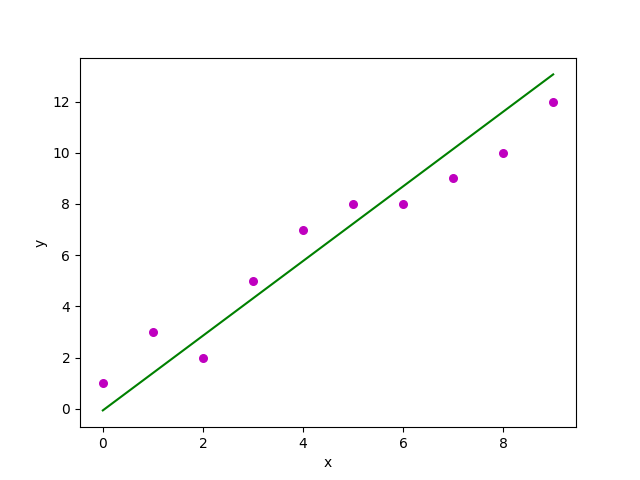

In [36]:
# LinearRegression model with default hyperparameter 
LR_model = LinearRegression(n_jobs=-1)
LR_model.fit(ori_dataset, train_y)
       
LR_prediction = LR_model.predict(ori_testset)

In [38]:
# Print out the MSE and MAE prediction for Linear Regression using original datasets
print("MSE of ori_data before tune:",metrics.mean_squared_error(test_y, LR_prediction))
print("MAE of ori_data before tune:",metrics.mean_absolute_error(test_y, LR_prediction))

MSE of ori_data before tune: 13.728896193887621
MAE of ori_data before tune: 2.0531327754247046


In [75]:
# Report function to tell results of the hyperparamter tuning
# will print out the rank, mean validation score, mean test score and parameters for each iteration
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} ".format(
                    results["mean_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

###  Hyperparameter Tuning for Linear Regression Using Randomized Search

In [39]:
# Set the hyperparameters for linear regression algorithm            
LR_params = {
    #two hyperparameters to be tuned
    'fit_intercept': [True, False],
    'normalize': [True, False],
}

LR_rand = RandomizedSearchCV(LR_model, LR_params, n_jobs=-1)
start = time()
LR_rand.fit(ori_dataset, train_y)
print("Time taken: ",(time()- start), "seconds\n")
report(LR_rand.cv_results_)

C:\Users\jingy\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Time taken:  13.523620367050171 seconds

Rank: 1
Mean validation score: 0.582 
Parameters: {'normalize': True, 'fit_intercept': False}

Rank: 1
Mean validation score: 0.582 
Parameters: {'normalize': False, 'fit_intercept': False}

Rank: 3
Mean validation score: 0.582 
Parameters: {'normalize': False, 'fit_intercept': True}



In [40]:
# After hyperparameter tuning, train the model with the best parameters

LR_model_tune = LinearRegression(normalize=True, fit_intercept=False)
LR_model_tune.fit(ori_dataset, train_y)

LR_prediction_tune = LR_model_tune.predict(ori_testset)

# Print out the MSE and MAE prediction for Linear Regression using original datasets after tuning
print("MSE of ori_data after tune:",metrics.mean_squared_error(test_y, LR_prediction_tune))
print("MAE of ori_data after tune:",metrics.mean_absolute_error(test_y, LR_prediction_tune))


MSE of ori_data after tune: 13.770285479291175
MAE of ori_data after tune: 2.052977047585891


## 1b) Linear Regression (Prior Data)

In [41]:
# LinearRegression model with default hyperparameter 
LR1_model = LinearRegression(n_jobs=-1)
#The model is trained using ori_dataset
LR1_model.fit(prior_dataset, train_y1)
        
LR1_prediction = LR1_model.predict(prior_testset)

In [42]:
# Print out the MSE and MAE prediction for Linear Regression using prior datasets
print("MSE of prior_data before tune:",metrics.mean_squared_error(test_y1, LR1_prediction))
print("MAE of prior_data before tune:",metrics.mean_absolute_error(test_y1, LR1_prediction))

MSE of prior_data before tune: 13.789734062115645
MAE of prior_data before tune: 2.0521039862263497


###  Hyperparameter Tuning for Linear Regression Using Randomized Search

In [43]:
# Hyperparameter tuning using randomized search

LR1_rand = RandomizedSearchCV(LR1_model, LR_params, n_jobs=-1)
start = time()
LR1_rand.fit(prior_dataset, train_y1)
print("Time taken: ",(time()- start), "seconds\n")
report(LR1_grid.cv_results_)

C:\Users\jingy\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Time taken:  30.59397006034851 seconds

Rank: 1
Mean validation score: -1120335915699375.375 
Parameters: {'normalize': False, 'fit_intercept': True}

Rank: 2
Mean validation score: -2620920551234201.000 
Parameters: {'normalize': True, 'fit_intercept': False}

Rank: 2
Mean validation score: -2620920551234201.000 
Parameters: {'normalize': False, 'fit_intercept': False}



In [25]:
# after hyperparameter tuning, train the model with the best parameters

LR1_model_tune = LinearRegression(normalize=False, fit_intercept=True, n_jobs=-1)
LR1_model_tune.fit(prior_dataset, train_y1)

LR1_prediction_tune = LR1_model_tune.predict(prior_testset)

#Print out the MSE and MAE prediction for Linear Regression using prior datasets
print("MSE of prior_data after tune:",metrics.mean_squared_error(test_y1, LR1_prediction_tune))
print("MAE of prior_data after tune:",metrics.mean_absolute_error(test_y1, LR1_prediction_tune))

MSE of prior_data after tune: 13.769716186250472
MAE of prior_data after tune: 2.052566560909235


## 2a) K-Nearest Neighbors (Original Data)
KNN regression is a non-parametric method which approximates the relationship between independent variables and the continuous outcome by averaging the observations in the same neighbourhood. It uses the kernel functions to weight the neighbors according to their distances. 

The size of neighborhood can be set through initializing n_neighbor
The KNN algorithm is simple to use but it might not be able to generalize unlike other algorithms, as it solely relies on the trained dataset.

Hyperparameter of KNN regression is n_neighbor

In [50]:
# KNN with default hyperparameter of n_neighbour = 5
KNN_model = KNeighborsRegressor(n_jobs=-1)
KNN_model.fit(ori_dataset, train_y)

KNN_prediction = KNN_model.predict(ori_testset)

In [51]:
# Print out the MSE and MAE prediction for Linear Regression using default hyperparameter and prior datasets
print("MSE of ori_data before tune:",metrics.mean_squared_error(test_y, KNN_prediction))
print("MAE of ori_data before tune:",metrics.mean_absolute_error(test_y, KNN_prediction))

MSE of ori_data before tune: 2.9132771
MAE of ori_data before tune: 0.7221902


###  Hyperparameter Tuning for KNN Using Randomized Search

In [52]:
# Hyperparameter tuning using randomized search
KNN_params = {
    #total of three hyperparameters to be tunes in KNN
    'n_neighbors': [5, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

KNN_rand = RandomizedSearchCV(KNN_model, KNN_params, n_iter=20, n_jobs=-1)
start = time()
KNN_rand.fit(ori_dataset, train_y)
print("Time taken: ",(time()- start), "seconds\n")
report(KNN_rand.cv_results_)

Time taken:  1466.4191536903381 seconds

Rank: 1
Mean validation score: 0.861 
Parameters: {'weights': 'distance', 'n_neighbors': 5, 'algorithm': 'auto'}

Rank: 2
Mean validation score: 0.861 
Parameters: {'weights': 'distance', 'n_neighbors': 5, 'algorithm': 'ball_tree'}

Rank: 3
Mean validation score: 0.858 
Parameters: {'weights': 'distance', 'n_neighbors': 10, 'algorithm': 'brute'}



In [26]:
# After hyperparameter tuning, train the model with the best parameters

KNN_model_tune = KNeighborsRegressor(weights='distance', n_neighbors=5, algorithm='auto', n_jobs=-1)
KNN_model_tune.fit(ori_dataset, train_y)

KNN_prediction_tune = KNN_model_tune.predict(ori_testset)

#Print MSE and MAE value for KNN using original atasets and default hyperparameter after tuning
print("MSE of ori_data after tune:",metrics.mean_squared_error(test_y, KNN_prediction_tune))
print("MAE of ori_data after tune:",metrics.mean_absolute_error(test_y, KNN_prediction_tune))

MSE of ori_data after tune: 2.72120451125752
MAE of ori_data after tune: 0.6881319898574542


## 2b) K-Nearest Neighbors (Prior Data)

In [58]:
# KNN with default hyperparameter of n_neighbour = 5
KNN1_model = KNeighborsRegressor(n_jobs=-1)
KNN1_model.fit(prior_dataset, train_y1)
        
KNN1_prediction = KNN1_model.predict(prior_testset)

In [59]:
# Print the MSE and MAE value for KNN using prior datasets and default hyperparameters
print("MSE of prior_data before tune:",metrics.mean_squared_error(test_y1, KNN1_prediction))
print("MAE of prior_data before tune:",metrics.mean_absolute_error(test_y1, KNN1_prediction))

MSE of prior_data before tune: 2.852759129391759
MAE of prior_data before tune: 0.717415352907626


###  Hyperparameter Tuning for KNN Using Randomized Search

In [60]:
KNN1_rand = RandomizedSearchCV(KNN1_model, KNN_params, n_iter=20, n_jobs=-1)
start = time()
KNN1_rand.fit(prior_dataset, train_y1)
print("Time taken: ",(time()- start), "seconds\n")
report(KNN1_rand.cv_results_)

Time taken:  3290.971821784973 seconds

Rank: 1
Mean validation score: 0.862 
Parameters: {'weights': 'distance', 'n_neighbors': 5, 'algorithm': 'ball_tree'}

Rank: 1
Mean validation score: 0.862 
Parameters: {'weights': 'distance', 'n_neighbors': 5, 'algorithm': 'kd_tree'}

Rank: 3
Mean validation score: 0.862 
Parameters: {'weights': 'distance', 'n_neighbors': 5, 'algorithm': 'brute'}

Rank: 3
Mean validation score: 0.862 
Parameters: {'weights': 'distance', 'n_neighbors': 5, 'algorithm': 'auto'}



In [27]:
# After hyperparameter tuning, train the model with the best parameters

KNN1_model_tune = KNeighborsRegressor(weights='distance', n_neighbors=5, algorithm='auto', n_jobs=-1)
KNN1_model_tune.fit(prior_dataset, train_y1)

KNN1_prediction_tune = KNN1_model_tune.predict(prior_testset)

# Print the MSE and MAE value of KNN using prior datasets after tuning
print("MSE of prior_data after tune:",metrics.mean_squared_error(test_y1, KNN1_prediction_tune))
print("MAE of prior_data after tune:",metrics.mean_absolute_error(test_y1, KNN1_prediction_tune))

MSE of prior_data after tune: 2.670367377374901
MAE of prior_data after tune: 0.6860283590225367


## 3a) Decision Tree (Original Data)
Decision tree can be used as a regression algorithm in the form of a tree-like structure. The idea of a decision tree is to divide different parameters of different factors/variable to different leaf nodes for the regression. Each parents node will split based on the criterion of relevant features and a conditional statement would be set on each parents nodes.
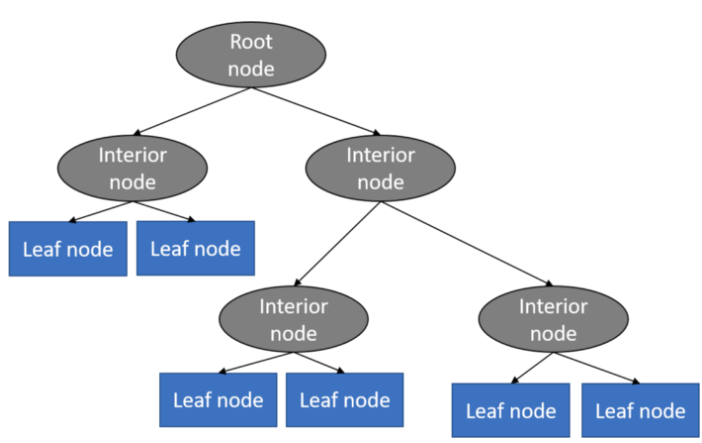
With a particular data point, it is run completely through the entirely tree by answering True/False questions to the conditional statement till it reaches the leaf node. The final prediction is the average of the value of the dependent variable in that particular leaf node.

In [28]:
# DecisionTreeRegressor using the default hyperparameters
DT_model = DecisionTreeRegressor()
DT_model.fit(ori_dataset, train_y)

DT_prediction = DT_model.predict(ori_testset)

In [30]:
# Print the MSE and MAE value for decision tree using original datasets and default hperparameter
print("MSE of ori_data before tune:",metrics.mean_squared_error(test_y, DT_prediction))
print("MAE of ori_data before tune:",metrics.mean_absolute_error(test_y, DT_prediction))

MSE of ori_data before tune: 3.2444091773848585
MAE of ori_data before tune: 0.7535215993889746


###  Hyperparameter Tuning for Decision Tree Using Randomized Search

In [34]:
DT_params = {
    # Total of three hyperparameters to be tuned in decision tree
    'splitter': ['best', 'random'],
    'max_depth': range(1, 20),
    'min_samples_leaf': range(1, 10),
}

DT_rand = RandomizedSearchCV(DT_model, DT_params, n_iter=20, n_jobs=-1)
start = time()
DT_rand.fit(ori_dataset, train_y)
print("Time taken: ",(time()- start), "seconds\n")
report(DT_rand.cv_results_)

Time taken:  327.4671621322632 seconds

Rank: 1
Mean validation score: 0.840 
Parameters: {'splitter': 'best', 'min_samples_leaf': 6, 'max_depth': 19}

Rank: 2
Mean validation score: 0.839 
Parameters: {'splitter': 'best', 'min_samples_leaf': 5, 'max_depth': 18}

Rank: 3
Mean validation score: 0.839 
Parameters: {'splitter': 'best', 'min_samples_leaf': 6, 'max_depth': 17}



In [37]:
# After hyperparameter tuning, train the model with the best parameters

DT_model_tune = DecisionTreeRegressor(splitter='best', min_samples_leaf=6, max_depth=19)
DT_model_tune.fit(ori_dataset, train_y)

DT_prediction_tune = DT_model_tune.predict(ori_testset)

# Print the MSE and MAE value of decision tree using original datasets and default hyperparameter after tuning
print("MSE of ori_data after tune:",metrics.mean_squared_error(test_y, DT_prediction_tune))
print("MAE of ori_data after tune:",metrics.mean_absolute_error(test_y, DT_prediction_tune))

MSE of ori_data after tune: 2.834693509855265
MAE of ori_data after tune: 0.730335395941416


## 3b) Decision Tree (Prior Data)

In [38]:
# Decision Tree algorithm using the default hyperparameters
DT1_model = DecisionTreeRegressor()
DT1_model.fit(prior_dataset, train_y1)
        
DT1_prediction = DT1_model.predict(prior_testset)

In [39]:
# Print the MSE and MAE value of decision tree using original datasets and default parameters
print("MSE of prior_data before tune:",metrics.mean_squared_error(test_y1, DT1_prediction))
print("MAE of prior_data before tune:",metrics.mean_absolute_error(test_y1, DT1_prediction))

MSE of prior_data before tune: 2.8602866750299567
MAE of prior_data before tune: 0.7213390302531418


###  Hyperparameter Tuning for Decision Tree Using Randomized Search

In [40]:
DT1_rand = RandomizedSearchCV(DT1_model, DT_params, n_iter=20, n_jobs=-1)
start = time()
DT1_rand.fit(prior_dataset, train_y1)
print("Time taken: ",(time()- start), "seconds\n")
report(DT1_rand.cv_results_)

Time taken:  823.7341561317444 seconds

Rank: 1
Mean validation score: 0.842 
Parameters: {'splitter': 'best', 'min_samples_leaf': 6, 'max_depth': 19}

Rank: 2
Mean validation score: 0.840 
Parameters: {'splitter': 'best', 'min_samples_leaf': 8, 'max_depth': 19}

Rank: 3
Mean validation score: 0.838 
Parameters: {'splitter': 'random', 'min_samples_leaf': 7, 'max_depth': 15}



In [45]:
# After hyperparameter tuning, train the model with the best parameters

DT1_model_tune = DecisionTreeRegressor(splitter='best', min_samples_leaf=6, max_depth=19)
DT1_model_tune.fit(prior_dataset, train_y1)

DT1_prediction_tune = DT1_model_tune.predict(prior_testset)

# Print the MSE and MAE value of decision tree using original datasets and default hyperparameters after tuning
print("MSE of prior_data after tune:",metrics.mean_squared_error(test_y1, DT1_prediction_tune))
print("MAE of prior_data after tune:",metrics.mean_absolute_error(test_y1, DT1_prediction_tune))

MSE of prior_data after tune: 2.5221189878758907
MAE of prior_data after tune: 0.7046688235021097


***
From the three algorithm above, **Decision Tree** gives the best performance with the lowest MSE of 2.5221 and lowest MAE of 0.7047.

Hence, we decided to implement tree based ensemble machine learning algorithm: **Random Forest, XGBoost** and **CatBoost** to obtain even better performance. 

## 4a) Random Forest (Original Data)

 Random Forest is a technique that utilises ensemble learning. It works by choosing a random training sample for training a decision tree and create a collection of individual trained predictors to solve the regression problem (Bagging). In a simple way, it uses many decision trees to solve a complex regression problem.
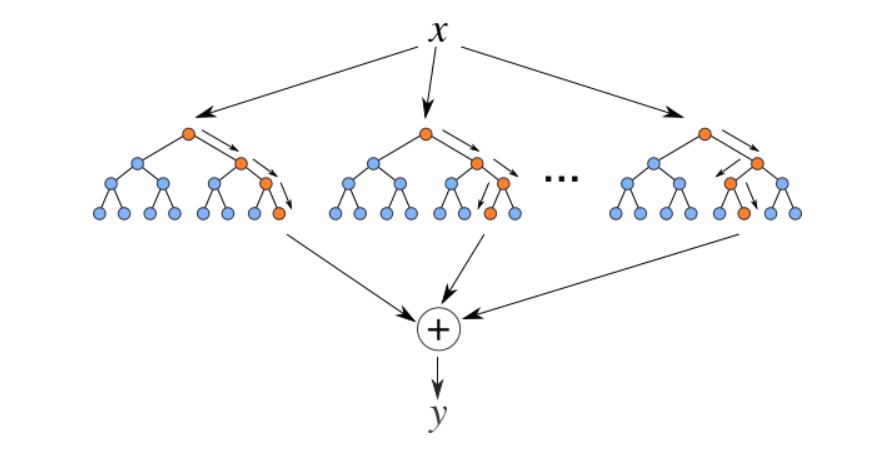
 It predicts by taking the average or mean of the output of many trees. It is more accurate than Decision Tree Learning as it can handle missing data effectively and solves overfitting.
 
 Its hyperparameter is max_depth and n-estimators

In [41]:
# Random Forest algorithm using the default hyperparaemter of n_estimators = 5
RF_model = RandomForestRegressor(n_estimators = 5, n_jobs=-1, random_state=0)
RF_model.fit(ori_dataset, train_y)

RF_prediction = RF_model.predict(ori_testset)

In [43]:
# Print the MSE and MAE value for random forest using original datasets
print("MSE of ori_data before tune:",metrics.mean_squared_error(test_y, RF_prediction))
print("MAE of ori_data before tune:",metrics.mean_absolute_error(test_y, RF_prediction))

MSE of ori_data before tune: 1.8770286939180778
MAE of ori_data before tune: 0.6373107806792755


###  Hyperparameter Tuning for Random Forest Using Randomized Search

In [76]:
RF_model = RandomForestRegressor()

RF_params = {
    # Total of three hyperparameters to be tuned
    'n_estimators': [10, 20, 25, 30],
    'max_leaf_nodes': [None, 10, 20],
    'min_samples_leaf': range(1, 5),
}
RF_rand = RandomizedSearchCV(RF_model, RF_params, n_iter=20, n_jobs=-1)
start = time()
RF_rand.fit(ori_dataset, train_y)
print("Time taken: ",(time()- start), "seconds\n")
report(RF_rand.cv_results_)

Time taken:  16155.426671504974 seconds

Rank: 1
Mean validation score: 0.902 
Parameters: {'n_estimators': 30, 'min_samples_leaf': 1, 'max_leaf_nodes': None}

Rank: 2
Mean validation score: 0.899 
Parameters: {'n_estimators': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': None}

Rank: 3
Mean validation score: 0.897 
Parameters: {'n_estimators': 25, 'min_samples_leaf': 3, 'max_leaf_nodes': None}



In [81]:
# After hyperparameter tuning, train the model with the best parameters

RF_model_tune = RandomForestRegressor(n_estimators=30, min_samples_leaf=1, max_leaf_nodes=None, n_jobs=-1)
RF_model_tune.fit(ori_dataset, train_y)

RF_prediction_tune = RF_model_tune.predict(ori_testset)

# Print the MSE and MAE value for random forest using original datasets after tuning
print("MSE of ori_data after tune:",metrics.mean_squared_error(test_y, RF_prediction_tune))
print("MAE of ori_data after tune:",metrics.mean_absolute_error(test_y, RF_prediction_tune))

MSE of ori_data after tune: 1.4267144608601179
MAE of ori_data after tune: 0.5622302329786104


## 4b) Random Forest (Prior Data)

In [24]:
# Random Forest algorithm using the default hyperparameter n_estimators = 5
RF1_model = RandomForestRegressor(n_estimators = 5, n_jobs=-1, random_state=0)
#fit prior_dataset and train_y1 into the random forest model
RF1_model.fit(prior_dataset, train_y1)

RF1_prediction = RF1_model.predict(prior_testset)

In [25]:
# Print the MSE and MAE value for random forest using prior datasets
print("MSE of prior_data before tune:",metrics.mean_squared_error(test_y1, RF1_prediction))
print("MAE of prior_data before tune:",metrics.mean_absolute_error(test_y1, RF1_prediction))

MSE of prior_data before tune: 1.5241724688505518
MAE of prior_data before tune: 0.5935518408500315


###  Hyperparameter Tuning for Random Forest Using Randomized Search

In [26]:
RF1_model = RandomForestRegressor()
RF1_rand = RandomizedSearchCV(RF1_model, RF_params, n_iter=20, n_jobs=-1)
start = time()
RF1_rand.fit(prior_dataset, train_y1)
print("Time taken: ",(time()- start), "seconds\n")
report(RF1_rand.cv_results_)

Time taken:  12023.6615691185 seconds

Rank: 1
Mean validation score: 0.911 
Parameters: {'n_estimators': 25, 'min_samples_leaf': 1, 'max_leaf_nodes': None}

Rank: 2
Mean validation score: 0.910 
Parameters: {'n_estimators': 20, 'min_samples_leaf': 1, 'max_leaf_nodes': None}

Rank: 3
Mean validation score: 0.909 
Parameters: {'n_estimators': 30, 'min_samples_leaf': 2, 'max_leaf_nodes': None}



In [82]:
# After hyperparameter tuning, train the model with the best parameters

RF1_model_tune = RandomForestRegressor(n_estimators=25, min_samples_leaf=1, max_leaf_nodes=None, n_jobs=-1)
RF1_model_tune.fit(prior_dataset, train_y1)

RF1_prediction_tune = RF1_model_tune.predict(prior_testset)

#print the MSE and MAE value for random forest using prior datasets after tuning
print("MSE of prior_data after tune:",metrics.mean_squared_error(test_y1, RF1_prediction_tune))
print("MAE of prior_data after tune:",metrics.mean_absolute_error(test_y1, RF1_prediction_tune))

MSE of prior_data after tune: 1.1559557673660799
MAE of prior_data after tune: 0.5205995022182982


## 5a) XGBoost (Original Data)

XGBoost is also a tree based ensemble machine learning algorithm but with a little twist to it. This algorithm adapted some restrictions to the making process of the decision tree. The restrictions impose that each decision tree must be a weak learners. Moreover, each decision trees are learned sequentially from the early decision trees by solving the net error from the prior decision tree. In other words, each decision trees is sequentially improving as it corrects the errors of its prior decision tree. The combinations of these decision trees is called Boosting, which is the key to this algorithm. Each decision trees would also result in an asymmetric trees. XGBoost build asymmetric trees.
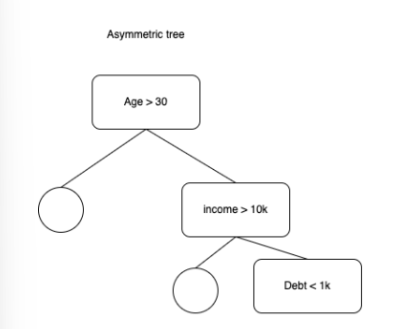

In [78]:
# XGBoost model with the optimal hyperparameter
XGB_model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', n_estimators=15, max_depth=10, n_jobs=-1))

In [79]:
XGB_model.fit(ori_dataset, train_y)
XGB_prediction = XGB_model.predict(ori_testset)

In [80]:
# Print the MSE and MAE value for XGBoost using original datasets
print("MSE of ori_data:",metrics.mean_squared_error(test_y, XGB_prediction))
print("MAE of ori_data:",metrics.mean_absolute_error(test_y, XGB_prediction))

MSE of ori_data: 1.671566
MAE of ori_data: 0.64282024


## 5b) XGBoost (Prior Data)

In [83]:
# XGBoost model with the optimal hyperparameter
XGB1_model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', n_estimators=15, max_depth=10, n_jobs=-1))

In [84]:
XGB1_model.fit(prior_dataset, train_y1)
XGB1_prediction = XGB1_model.predict(prior_testset)

In [85]:
# Print the MSE and MAE value for XGBoost using prior datasets
print("MSE of prior_data:",metrics.mean_squared_error(test_y1, XGB1_prediction))
print("MAE of prior_data:",metrics.mean_absolute_error(test_y1, XGB1_prediction))

MSE of prior_data: 1.3550031
MAE of prior_data: 0.5959815


## 6a) CatBoost (Original data)

Catboost is also a tree based ensemble machine learning algorithm and a variant of the XGBoost. It builds symmetric trees instead which is very stable as the resulting qualities does not change alot during hyperparameter tuning.
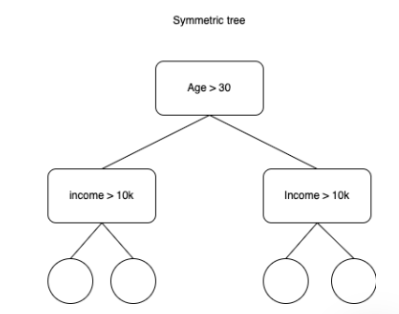

In [27]:
# CatBoost model with the optimal hyperparameter
CB_model = CatBoostRegressor(depth=10, iterations=25, learning_rate=0.3, loss_function='MultiRMSE', eval_metric='MultiRMSE')
CB_model.fit(ori_dataset, train_y)

CB_prediction = CB_model.predict(ori_testset)

0:	learn: 39.5684175	total: 23.6s	remaining: 9m 26s
1:	learn: 33.3152925	total: 46.5s	remaining: 8m 54s
2:	learn: 29.0004514	total: 1m 9s	remaining: 8m 30s
3:	learn: 26.1444154	total: 1m 32s	remaining: 8m 7s
4:	learn: 24.3282671	total: 1m 55s	remaining: 7m 43s
5:	learn: 22.8687732	total: 2m 20s	remaining: 7m 24s
6:	learn: 21.8431486	total: 2m 44s	remaining: 7m 3s
7:	learn: 20.8656307	total: 3m 9s	remaining: 6m 41s
8:	learn: 20.1238163	total: 3m 34s	remaining: 6m 21s
9:	learn: 19.5726746	total: 4m	remaining: 6m
10:	learn: 19.0290181	total: 4m 23s	remaining: 5m 35s
11:	learn: 18.6309345	total: 4m 48s	remaining: 5m 12s
12:	learn: 18.3295002	total: 5m 11s	remaining: 4m 47s
13:	learn: 17.9822413	total: 5m 34s	remaining: 4m 22s
14:	learn: 17.7273431	total: 5m 59s	remaining: 3m 59s
15:	learn: 17.4802953	total: 6m 24s	remaining: 3m 36s
16:	learn: 17.2383931	total: 6m 47s	remaining: 3m 11s
17:	learn: 16.9609069	total: 7m 9s	remaining: 2m 47s
18:	learn: 16.8109677	total: 7m 32s	remaining: 2m 22s

In [28]:
# Print the MSE and MAE value for CatBoost using original datasets
print("MSE of ori_data:",metrics.mean_squared_error(test_y, CB_prediction))
print("MAE of ori_data:",metrics.mean_absolute_error(test_y, CB_prediction))

MSE of ori_data: 3.3445849680788493
MAE of ori_data: 0.9817844342073039


## 6b) CatBoost (Prior data)

In [29]:
# CatBoost model with optimal hyperparameter
CB1_model = CatBoostRegressor(depth=10, iterations=25, learning_rate=0.3, loss_function='MultiRMSE', eval_metric='MultiRMSE')
CB1_model.fit(prior_dataset, train_y1)

CB1_prediction = CB1_model.predict(prior_testset)

0:	learn: 38.8254558	total: 46.1s	remaining: 18m 26s
1:	learn: 32.5543991	total: 1m 31s	remaining: 17m 32s
2:	learn: 28.3092955	total: 2m 17s	remaining: 16m 48s
3:	learn: 25.2356232	total: 3m 7s	remaining: 16m 24s
4:	learn: 22.9423520	total: 3m 53s	remaining: 15m 35s
5:	learn: 21.3232807	total: 4m 39s	remaining: 14m 46s
6:	learn: 20.1574378	total: 5m 26s	remaining: 13m 59s
7:	learn: 19.3193571	total: 6m 12s	remaining: 13m 10s
8:	learn: 18.5705680	total: 6m 57s	remaining: 12m 21s
9:	learn: 17.9134663	total: 7m 44s	remaining: 11m 36s
10:	learn: 17.2326039	total: 8m 31s	remaining: 10m 50s
11:	learn: 16.8569884	total: 9m 16s	remaining: 10m 2s
12:	learn: 16.5493168	total: 10m	remaining: 9m 14s
13:	learn: 16.1777425	total: 10m 46s	remaining: 8m 27s
14:	learn: 15.8091525	total: 11m 32s	remaining: 7m 41s
15:	learn: 15.5636342	total: 12m 19s	remaining: 6m 55s
16:	learn: 15.2792636	total: 13m 6s	remaining: 6m 9s
17:	learn: 15.0869365	total: 13m 51s	remaining: 5m 23s
18:	learn: 14.8686070	total: 

In [30]:
# Print the MSE and MAE value of CatBoost using prior datasets
print("MSE of prior_data:",metrics.mean_squared_error(test_y1, CB1_prediction))
print("MAE of prior_data:",metrics.mean_absolute_error(test_y1, CB1_prediction))

MSE of prior_data: 2.5568879180326887
MAE of prior_data: 0.874705864767021


***
# Results

We had used three different types of processed data to train our models which are:
- (a) Dataset with no prior time step and no flattening 80 rows into one row
- (b) Dataset with no prior time step but with flattening 80 rows into one row
- (c) Dataset that consider 1 time step prior and flattening 80 rows into one row

The Mean Squared Error (MSE) and Mean Absoulute Error (MAE) for each algorithm are summarized into the table below.

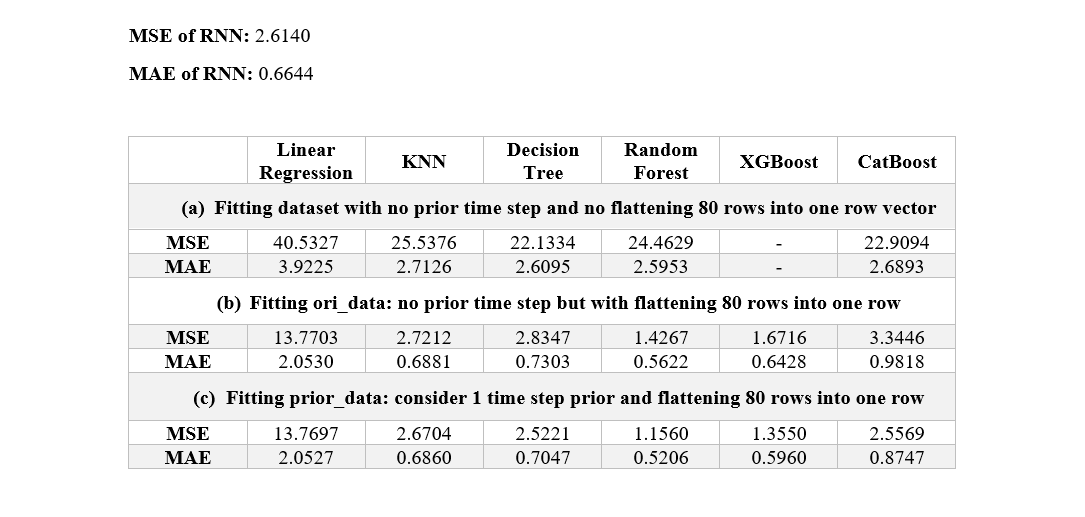

The results in the above table shows that the models performance are improving and get the best result with dataset (c).
Hence, we can conclude that feature engineering is very critical to improve our model performance for classical machine learning algorithm.

Besides, **Random Forest** and **XGBoost** had outperform **Recurrent Neural Network** in solving this Covid-19 ventilator control problem which proves to us that neural network does not always offer the best solution.

---
# Discussion

## 1. An Unfair Comparison
Although from the results above we had concluded that the **Recurrent Neural Network** does not give the best performance, it is important to note that this conclusion might not always be True due to our limitations: time constraint and computational power. 
  
With hyperparameter tuning such as the number of epochs, number of neurons used in a layer, **Recurrent Neural Network** might give a better performance. However, such operations are computationally expensive and time consuming.

## 2. Performance of Linear Regression
**Linear Regression** is highly sensitive to the range of the data points. However, in this project we did not scale our data to zero mean and unit variance. Therefore, it is expected that **Linear Regression** gives the worst performance.


## 3. Performance of Tree Based Model
**Decision Tree, Random Forest, XGBoost** and **CatBoost** give a good performance in general while solving this Covid-19 ventilator control problem. This is because tree based model can work well with little data preparation. Hence, the unscaled data did not affect the model performance.

## 4. Future of The Project
Although we are quite satify with the performance of our project, here are a few improvements that we think can implement to furthur improves our machine learning models.

- Manually adding noise to our dataset before training the neural network so it can be more resistance to noise when predicting the pressure of an unseen dataset and gives a better performance.
- Adding data from more time step prior, for example: 5 time step prior before fitting it in our classical machine learning algorithm. 
